<h1> Homework 3 MNIST Classifier <h1>

This notebook shows practices of image classifier using singler layer training and double layer training with ReLu. </br> 
Each training will show training model accuracy and valdation model accuracy. 

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)
set_seed(0)
num_imgs_per_digit = 500
items = [
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit]
]
block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")

5000 training images, 5000 validation images


**Show Loaded Data batch**

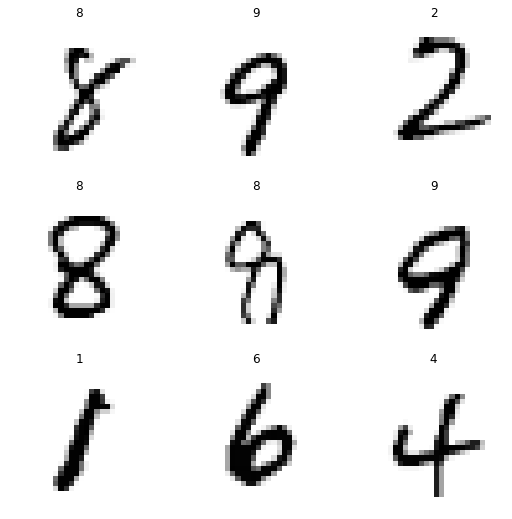

In [2]:
dataloaders.train.show_batch()

In [3]:
print(f"Available categories: {dataloaders.train.vocab}")

Available categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
images, labels = dataloaders.train.one_batch()
images = cast(images, Tensor)
labels = cast(labels, Tensor)
images.shape

torch.Size([16, 1, 28, 28])

In [5]:
flattener = nn.Flatten()

In [6]:
flattener(images).shape

torch.Size([16, 784])

In [7]:
linear_1 = nn.Linear(in_features=784, out_features=10, bias=False)

model = nn.Sequential(
    flattener,
    linear_1,
)

In [8]:
model.to(images.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=False)
)

In [9]:
logits = model(images)
assert logits.shape == (16, 10)

In [10]:
logits[0]

tensor([ 0.0977,  0.1462,  0.0740, -0.1660, -0.1028,  0.2892, -0.1130,  0.1986,
        -0.2794,  0.1695], device='cuda:0', grad_fn=<SelectBackward0>)

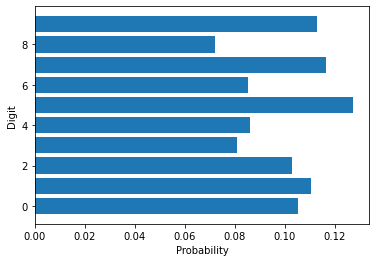

In [11]:
probs = logits.softmax(dim=-1)
plt.barh(torch.arange(10), probs[0].detach().cpu()); plt.xlabel("Probability"); plt.ylabel("Digit");

In [12]:
labels

tensor([0, 9, 8, 6, 0, 6, 8, 3, 1, 6, 5, 0, 0, 7, 7, 9], device='cuda:0')

In [13]:
loss = F.cross_entropy(logits, labels, reduction='none')
loss

tensor([2.2513, 2.2094, 2.1502, 2.4702, 2.2340, 2.4753, 2.0471, 2.5374, 2.1118,
        2.4839, 2.4328, 2.0901, 2.4432, 1.9929, 2.1390, 2.3107],
       device='cuda:0', grad_fn=<NllLossBackward0>)

In [14]:
loss.mean()

tensor(2.2737, device='cuda:0', grad_fn=<MeanBackward0>)

In [15]:
F.nll_loss(probs.log(), labels, reduction='none').mean()

tensor(2.2737, device='cuda:0', grad_fn=<MeanBackward0>)

In [16]:
predictions = logits.argmax(dim=1)
print(predictions.shape)
predictions

torch.Size([16])


tensor([5, 2, 7, 9, 5, 8, 8, 8, 1, 7, 1, 9, 5, 7, 2, 2], device='cuda:0')

<h2>Training Loop<h2>

Epoch  0: loss=1.44, train accuracy 71.05%, validation accuracy 81.88%
Epoch  1: loss=1.13, train accuracy 83.91%, validation accuracy 85.10%
Epoch  2: loss=0.98, train accuracy 86.28%, validation accuracy 86.06%
Epoch  3: loss=0.88, train accuracy 86.84%, validation accuracy 86.60%
Epoch  4: loss=0.81, train accuracy 87.96%, validation accuracy 87.22%
Epoch  5: loss=0.75, train accuracy 88.64%, validation accuracy 87.44%
Epoch  6: loss=0.71, train accuracy 88.78%, validation accuracy 87.70%
Epoch  7: loss=0.68, train accuracy 89.30%, validation accuracy 88.10%
Epoch  8: loss=0.65, train accuracy 89.52%, validation accuracy 88.22%
Epoch  9: loss=0.63, train accuracy 89.76%, validation accuracy 88.24%
Epoch 10: loss=0.61, train accuracy 89.92%, validation accuracy 88.46%
Epoch 11: loss=0.59, train accuracy 90.08%, validation accuracy 88.76%
Epoch 12: loss=0.57, train accuracy 90.34%, validation accuracy 88.86%
Epoch 13: loss=0.56, train accuracy 90.28%, validation accuracy 88.74%
Epoch 

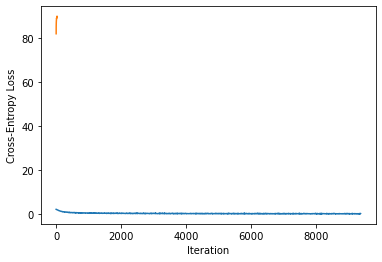

In [17]:
del images, labels, logits, loss, probs, predictions
num_epochs = 30 
learning_rate = 0.01
losses = []
train_accs = []
valid_accs = []

linear_1.reset_parameters()

for epoch in range(num_epochs):
    total_images_train = 0
    total_correct_train = 0

    for images, labels in dataloaders.train:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        logits = model(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        loss.backward()
        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
        model.zero_grad()
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images_train += len(labels)
        total_correct_train += num_accurate
        losses.append(loss.item())
    train_acc = 100 * total_correct_train / total_images_train
    train_accs.append(train_acc)


    model.eval()
    total_images_valid = 0
    total_correct_valid = 0

    for images, labels in dataloaders.valid:
        images = cast(images, Tensor) 
        labels = cast(labels, Tensor)
        with torch.no_grad():
            logits = model(images)
            loss = F.cross_entropy(logits, labels, reduction='none').mean()
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images_valid += len(labels)
        total_correct_valid += num_accurate
    valid_acc = 100 * total_correct_valid / total_images_valid
    valid_accs.append(valid_acc)

    avg_loss_this_epoch = np.mean(losses[-total_images_train:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {train_acc:.2f}%, validation accuracy {valid_acc:.2f}%")

pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");
plt.plot(valid_accs, label="Validation accuracy")


<h2> 2 Layer Training <h2>

In [18]:
linear_1 = nn.Linear(in_features=784, out_features=10, bias=True)
linear_2 = nn.Linear(in_features=10, out_features=10, bias=True)
model = nn.Sequential(
    flattener,
    linear_1,
    nn.ReLU(),
    linear_2
    
)

plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
model.to(images.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
)

In [20]:
logits = model(images)

In [21]:
logits[0]

tensor([ 0.2029, -0.1277, -0.2586,  0.0789,  0.2938,  0.2487, -0.1420, -0.0969,
         0.0366, -0.0323], device='cuda:0', grad_fn=<SelectBackward0>)

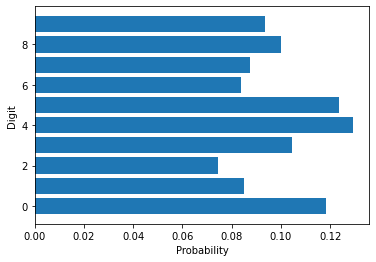

In [22]:
probs = logits.softmax(dim=-1)
plt.barh(torch.arange(10), probs[0].detach().cpu()); plt.xlabel("Probability"); plt.ylabel("Digit");

In [23]:
labels

tensor([9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')

In [24]:
loss = F.cross_entropy(logits, labels, reduction='none')
loss

tensor([2.3706, 2.3937, 2.4125, 2.4152, 2.3594, 2.4158, 2.4204, 2.3752],
       device='cuda:0', grad_fn=<NllLossBackward0>)

In [25]:
loss.mean()

tensor(2.3954, device='cuda:0', grad_fn=<MeanBackward0>)

In [26]:
F.nll_loss(probs.log(), labels, reduction='none').mean()

tensor(2.3954, device='cuda:0', grad_fn=<MeanBackward0>)

In [27]:
predictions = logits.argmax(dim=1)
print(predictions.shape)
predictions

torch.Size([8])


tensor([4, 4, 4, 4, 0, 4, 4, 4], device='cuda:0')

In [28]:
del images, labels, logits, loss, probs, predictions

Epoch  0: loss=2.03, train accuracy 40.26%, validation accuracy 58.66%
Epoch  1: loss=1.67, train accuracy 70.69%, validation accuracy 78.50%
Epoch  2: loss=1.40, train accuracy 80.71%, validation accuracy 82.36%
Epoch  3: loss=1.21, train accuracy 83.89%, validation accuracy 85.04%
Epoch  4: loss=1.07, train accuracy 86.28%, validation accuracy 86.04%
Epoch  5: loss=0.97, train accuracy 87.20%, validation accuracy 87.12%
Epoch  6: loss=0.90, train accuracy 87.88%, validation accuracy 87.26%
Epoch  7: loss=0.83, train accuracy 88.62%, validation accuracy 87.98%
Epoch  8: loss=0.78, train accuracy 89.40%, validation accuracy 88.26%
Epoch  9: loss=0.74, train accuracy 90.00%, validation accuracy 88.42%
Epoch 10: loss=0.71, train accuracy 90.30%, validation accuracy 88.36%
Epoch 11: loss=0.67, train accuracy 90.54%, validation accuracy 89.24%
Epoch 12: loss=0.65, train accuracy 90.85%, validation accuracy 89.08%
Epoch 13: loss=0.62, train accuracy 91.03%, validation accuracy 89.34%
Epoch 

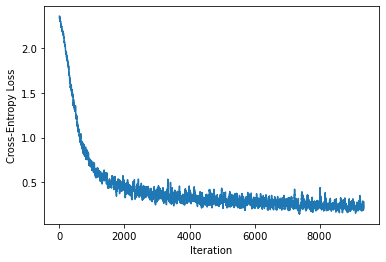

In [29]:
num_epochs = 30 
learning_rate = 0.01
losses = []
train_accs = []
valid_accs = []

linear_1.reset_parameters()
linear_2.reset_parameters()

for epoch in range(num_epochs):
    total_images_train = 0
    total_correct_train = 0

    for images, labels in dataloaders.train:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        logits = model(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        loss.backward()
        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
        model.zero_grad()
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images_train += len(labels)
        total_correct_train += num_accurate
        losses.append(loss.item())
    train_acc = 100 * total_correct_train / total_images_train
    train_accs.append(train_acc)


    model.eval()
    total_images_valid = 0
    total_correct_valid = 0

    for images, labels in dataloaders.valid:
        images = cast(images, Tensor) 
        labels = cast(labels, Tensor)
        with torch.no_grad():
            logits = model(images)
            loss = F.cross_entropy(logits, labels, reduction='none').mean()
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images_valid += len(labels)
        total_correct_valid += num_accurate
    valid_acc = 100 * total_correct_valid / total_images_valid
    valid_accs.append(valid_acc)

    avg_loss_this_epoch = np.mean(losses[-total_images_train:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {train_acc:.2f}%, validation accuracy {valid_acc:.2f}%")

pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");
plt.plot(avg_loss_this_epoch, label="Validation loss")


**Reflective Question**

**What did you learn about neural networks from this exercise?**


In this exercise, we used neural network to classify images of hand written digits. Neural network has layers, meaning it consitsts of one or more layers of nuerons. We used neural network with input later, hidden layers, and output layer. Because it needs training, we have trained these nueral layers and also validated each epochs. I also have learned that there are "Hidden Layers" and we have used two hidden layers. 

**What did you learn about your own problem-solving process?**

Building from the scratch, I had a chance to realize what I was not understanding from lessons learned until now. Specifically, I have learned about what train, validation, test models are and how they differs from each other. Also by breaking down the complex problem to a more simpler and step by step progress, I was able to see hown approach more complex problem in a more manageable manner. 

**How would you describe this experience in a job interview?**

I would talk about 3 main things about this experience.</br></br>
- Problem solving skills: I would discuss about how I was building image classifying ml model from scratch, and what kind of difficulties I had. I would explain the process how I broke up things to look at the project in a more simpler manner. </br></br>
- technical skills: I would discuss about how I used python tensor and pytorch libraries and my understandings on train, validation, and test models. </br></br>
- Process or self-learning and growth: I would explain how I was very confused and lost in the beginning as I had trouble understanding the content, but through researches on internet and investing some time learning before coding and debugging, I was able to speed up my process and figure out what I was supposed to do.